In [462]:
"""Lennard-Jones for specific atom"""

import numpy as np

class atom_props():
    def __init__(self, sigma, epsilon):
        self.sig = sigma
        self.eps = epsilon

def pot_LJ(atom,r):
    sig = atom.sig
    eps = atom.eps
    return 4*eps*((sig/r)**12 - (sig/r)**6)   

def pot_LJ_dl(r):
    u = np.zeros(r.shape)
    u[r != 0] = 4*((1/r[r != 0])**12 - (1/r[r != 0])**6)   
    u[r == 0] = 0 
    return u

def grad_pot_LJ_dl(r):
    u = np.zeros(r.shape)
    u[r != 0] = -24*(2*(1/r[r != 0])**13 - (1/r[r != 0])**7)   
    u[r == 0] = 0 
    return u

# Initiazlize box and particles
def particle_generator(L, N, dim):
    x_init = np.random.random((dim,N))*L
    v_init = np.zeros((dim,N),dtype=float)
    return x_init, v_init

def particle_dist(L, N, x, dim):
    # Particles NN, differences, coordinates

    # Calcolate distances to NN
    r = np.zeros((N,N),dtype=float)
    NN_max_dist = L/2
    # xv = np.zeros((dim,N,N),dtype=float)
    delta_tot = np.zeros((dim,N,N))
    
    for i in range(dim):
        # Difference between coordinates per dimension
        delta = x[i,:]-np.transpose([x[i,:]])
        '''
        # look for NN, define 'virtual' points
        xv[i,:,:] =  np.tile(x[i,:].reshape(N,1),N)
        xv[i][delta > NN_max_dist] = L + xv[i][delta > NN_max_dist] 
        xv[i][delta < -NN_max_dist] = -L + xv[i][delta < -NN_max_dist] 
        '''
        # New difference including 'virtual' coordinates
        delta[delta > NN_max_dist] = -delta[delta > NN_max_dist]%L
        delta[delta < -NN_max_dist] = delta[delta < -NN_max_dist]%L
       
        delta_tot[i] = delta
        r += delta**2   
        r = np.sqrt(r) 
        
    return delta_tot, r

def pot_and_force(delta_tot, r, dim, N):
    # Potentials and Forces
    F = np.zeros((dim,N,N),dtype=float)
    U = pot_LJ_dl(r)
    
    for i in range(dim):
        F[i][r != 0] = -grad_pot_LJ_dl(r[r != 0])*delta_tot[i][r != 0]/(r[r != 0])
        print("F",F)
    F_sum = F.sum(axis=1)
    print("Fsum",F_sum)
   
    return F_sum, U

In [425]:
# Plotting the potential for Argon
import matplotlib.pyplot as plt
k_b = 1.38e-23
argon = atom_props(3.405e-10, k_b*119.8)        

x_t = np.linspace(0.9,5,1000)
u_t = pot_LJ_dl(x_t);

plt.plot(x_t,u_t)
plt.xlabel(r'Distance r/$\sigma$')
plt.ylabel(r'Energy u/$\epsilon$')


   

In [464]:

# Initial positions
L = 5 # Box size
N = 3 # partciles
dim = 2 # Dimensions of the probem

x_init, v_init = particle_generator(L, N, dim) 


In [465]:
import copy as cp

delta_t = 1e-4
t_range = np.arange(0, 100*delta_t, delta_t)
E_kin = np.zeros((len(t_range),1), dtype=float)
E_pot = np.zeros((len(t_range),1), dtype=float)

x = cp.deepcopy(x_init)
v = cp.deepcopy(v_init)

for i, t in enumerate(t_range):
    delta_tot, r = particle_dist(L, N, x, dim)
    F, U = pot_and_force(delta_tot, r, dim, N)
    # step_size = np.sum((abs((v * delta_t)) > 0.0005))
    x += v * delta_t
    v += F * delta_t
    x[x > L] = (x[x > L]%L)
    x[x < 0] = abs((x[x < 0]%L))
    
    # Fix energy conservation with direction of the kinetic energy
    E_kin[i] = (v**2).sum(axis=1).sum(axis=0)
    E_pot[i] = U.sum(axis=1).sum(axis=0)
    
    plt.plot(x[0,0],x[1,0],'go')
    plt.plot(x[0,1],x[1,1],'yo')
    '''
    if step_size !=0:
        
        for i in range(N):
            plt.plot([x[0,i],x[0,i]+F[0,i]/sum(sum(abs(F)))],[x[1,i],x[1,i]+F[1,i]/sum(sum(abs(F)))])
    '''
    


F [[[  0.00000000e+00   9.12866239e+06  -2.46773837e-01]
  [ -9.12866239e+06   0.00000000e+00  -1.41644094e-01]
  [ -2.46773837e-01  -1.41644094e-01   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]]
F [[[  0.00000000e+00   9.12866239e+06  -2.46773837e-01]
  [ -9.12866239e+06   0.00000000e+00  -1.41644094e-01]
  [ -2.46773837e-01  -1.41644094e-01   0.00000000e+00]]

 [[  0.00000000e+00   1.41402860e+07   3.04470859e-01]
  [ -1.41402860e+07   0.00000000e+00   1.78372853e-01]
  [ -3.04470859e-01  -1.78372853e-01   0.00000000e+00]]]
Fsum [[ -9.12866264e+06   9.12866225e+06  -3.88417931e-01]
 [ -1.41402863e+07   1.41402858e+07   4.82843712e-01]]
F [[[  0.00000000e+00   9.12866239e+06  -2.46773837e-01]
  [ -9.12866239e+06   0.00000000e+00  -1.41644094e-01]
  [ -2.46773837e-01  -1.41644094e-01   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00   0.0000

F [[[  0.          22.79140312  -0.53470489]
  [-22.79140312   0.          -1.05733831]
  [  0.53470489   1.05733831   0.        ]]

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]]
F [[[  0.          22.79140312  -0.53470489]
  [-22.79140312   0.          -1.05733831]
  [  0.53470489   1.05733831   0.        ]]

 [[  0.          -4.53387532   0.39528896]
  [  4.53387532   0.           1.75492394]
  [ -0.39528896  -1.75492394   0.        ]]]
Fsum [[-22.25669823  23.84874144  -1.5920432 ]
 [  4.13858636  -6.28879927   2.15021291]]
F [[[ 0.         -2.51708501 -1.21802534]
  [ 2.51708501  0.         -0.56620365]
  [ 1.21802534  0.56620365  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]
F [[[ 0.         -2.51708501 -1.21802534]
  [ 2.51708501  0.         -0.56620365]
  [ 1.21802534  0.56620365  0.        ]]

 [[ 0.      

F [[[ 0.         -0.14770422 -0.36507744]
  [ 0.14770422  0.         -0.00075957]
  [ 0.36507744  0.00075957  0.        ]]

 [[ 0.         -0.31655163  0.65462066]
  [-0.31655163  0.         -0.14535059]
  [-0.65462066  0.14535059  0.        ]]]
Fsum [[ 0.51278166 -0.14694465 -0.36583701]
 [-0.97117228 -0.17120103  0.50927006]]
F [[[ 0.         -0.02176716 -1.11315674]
  [ 0.02176716  0.          0.03184413]
  [ 1.11315674 -0.03184413  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]
F [[[ 0.         -0.02176716 -1.11315674]
  [ 0.02176716  0.          0.03184413]
  [ 1.11315674 -0.03184413  0.        ]]

 [[ 0.         -0.04353462  1.25241714]
  [-0.04353462  0.         -0.30193699]
  [-1.25241714  0.30193699  0.        ]]]
Fsum [[ 1.13492389 -0.05361129 -1.0813126 ]
 [-1.29595176  0.25840236  0.95048016]]
F [[[ 0.         -0.02123091 -2.04427944]
  [ 0.02123091  0.          0.15362515]
  [ 2.044279

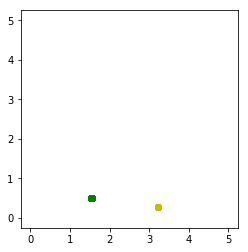

In [455]:
plt.plot(0,0)
plt.plot(L,L)
plt.axis('square')            
plt.show()

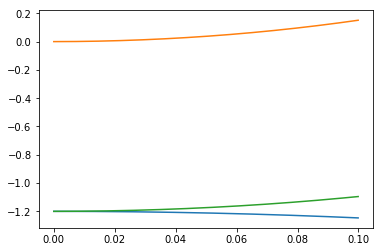

In [456]:
plt.plot(t_range,E_pot)
plt.plot(t_range,E_kin)
plt.plot(t_range,E_kin+E_pot)
plt.show()

In [439]:
U.sum(axis=1).sum(axis=0)

-1.2003448860095745

In [457]:
F

array([[ 2.75975003, -2.75975003],
       [-0.37423254,  0.37423254]])